
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Итоговый проект. Базовый поток. Весна 2021</b></h3>
<h3 style="text-align: center;"><b>Тема проекта: "Discover the mysteries of the Maya"</b></h3>
<p style="align: center;"><img align=center src="https://biasvariancelabs.github.io/maya_challenge/images/remotesensing-12-02215-g003.jpg" width=600 height=400/></p>





Work performed by Ivan Kochkurov

Stepik User ID: 327138733

https://github.com/matroskinsk

#Description of tasks

Задача состоит в том, чтобы определить местонахождение древних архитектур майя (агуады, платформы и здания) путем выполнения комплексной сегментации изображений различных типов данных спутниковых снимков и данных лазерного сканирования с воздуха (ALS, лидар)

Исходные данные:
При регистрации на конкурс "Discover the mysteries of the Maya" был получен датасет состоящий из различных типов спутниковых изображений ([из Sentinel-1 и Sentinel-2](https://biasvariancelabs.github.io/maya_challenge/res/S1%20and%20S2%20TIFF%20file%20structure.pdf
)) и данных воздушного лазерного сканирования (данные лидара)

[Информация по каналам с Sentinel-1](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/naming-conventions
)

[Информация по каналам с Sentinel-2](https://www.hatarilabs.com/ih-en/how-many-spectral-bands-have-the-sentinel-2-images
)



#License

Работа выполнялась на основе набора инструментов AiTALAS
MIT License

Copyright (c) 2020 Bias Variance Labs

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

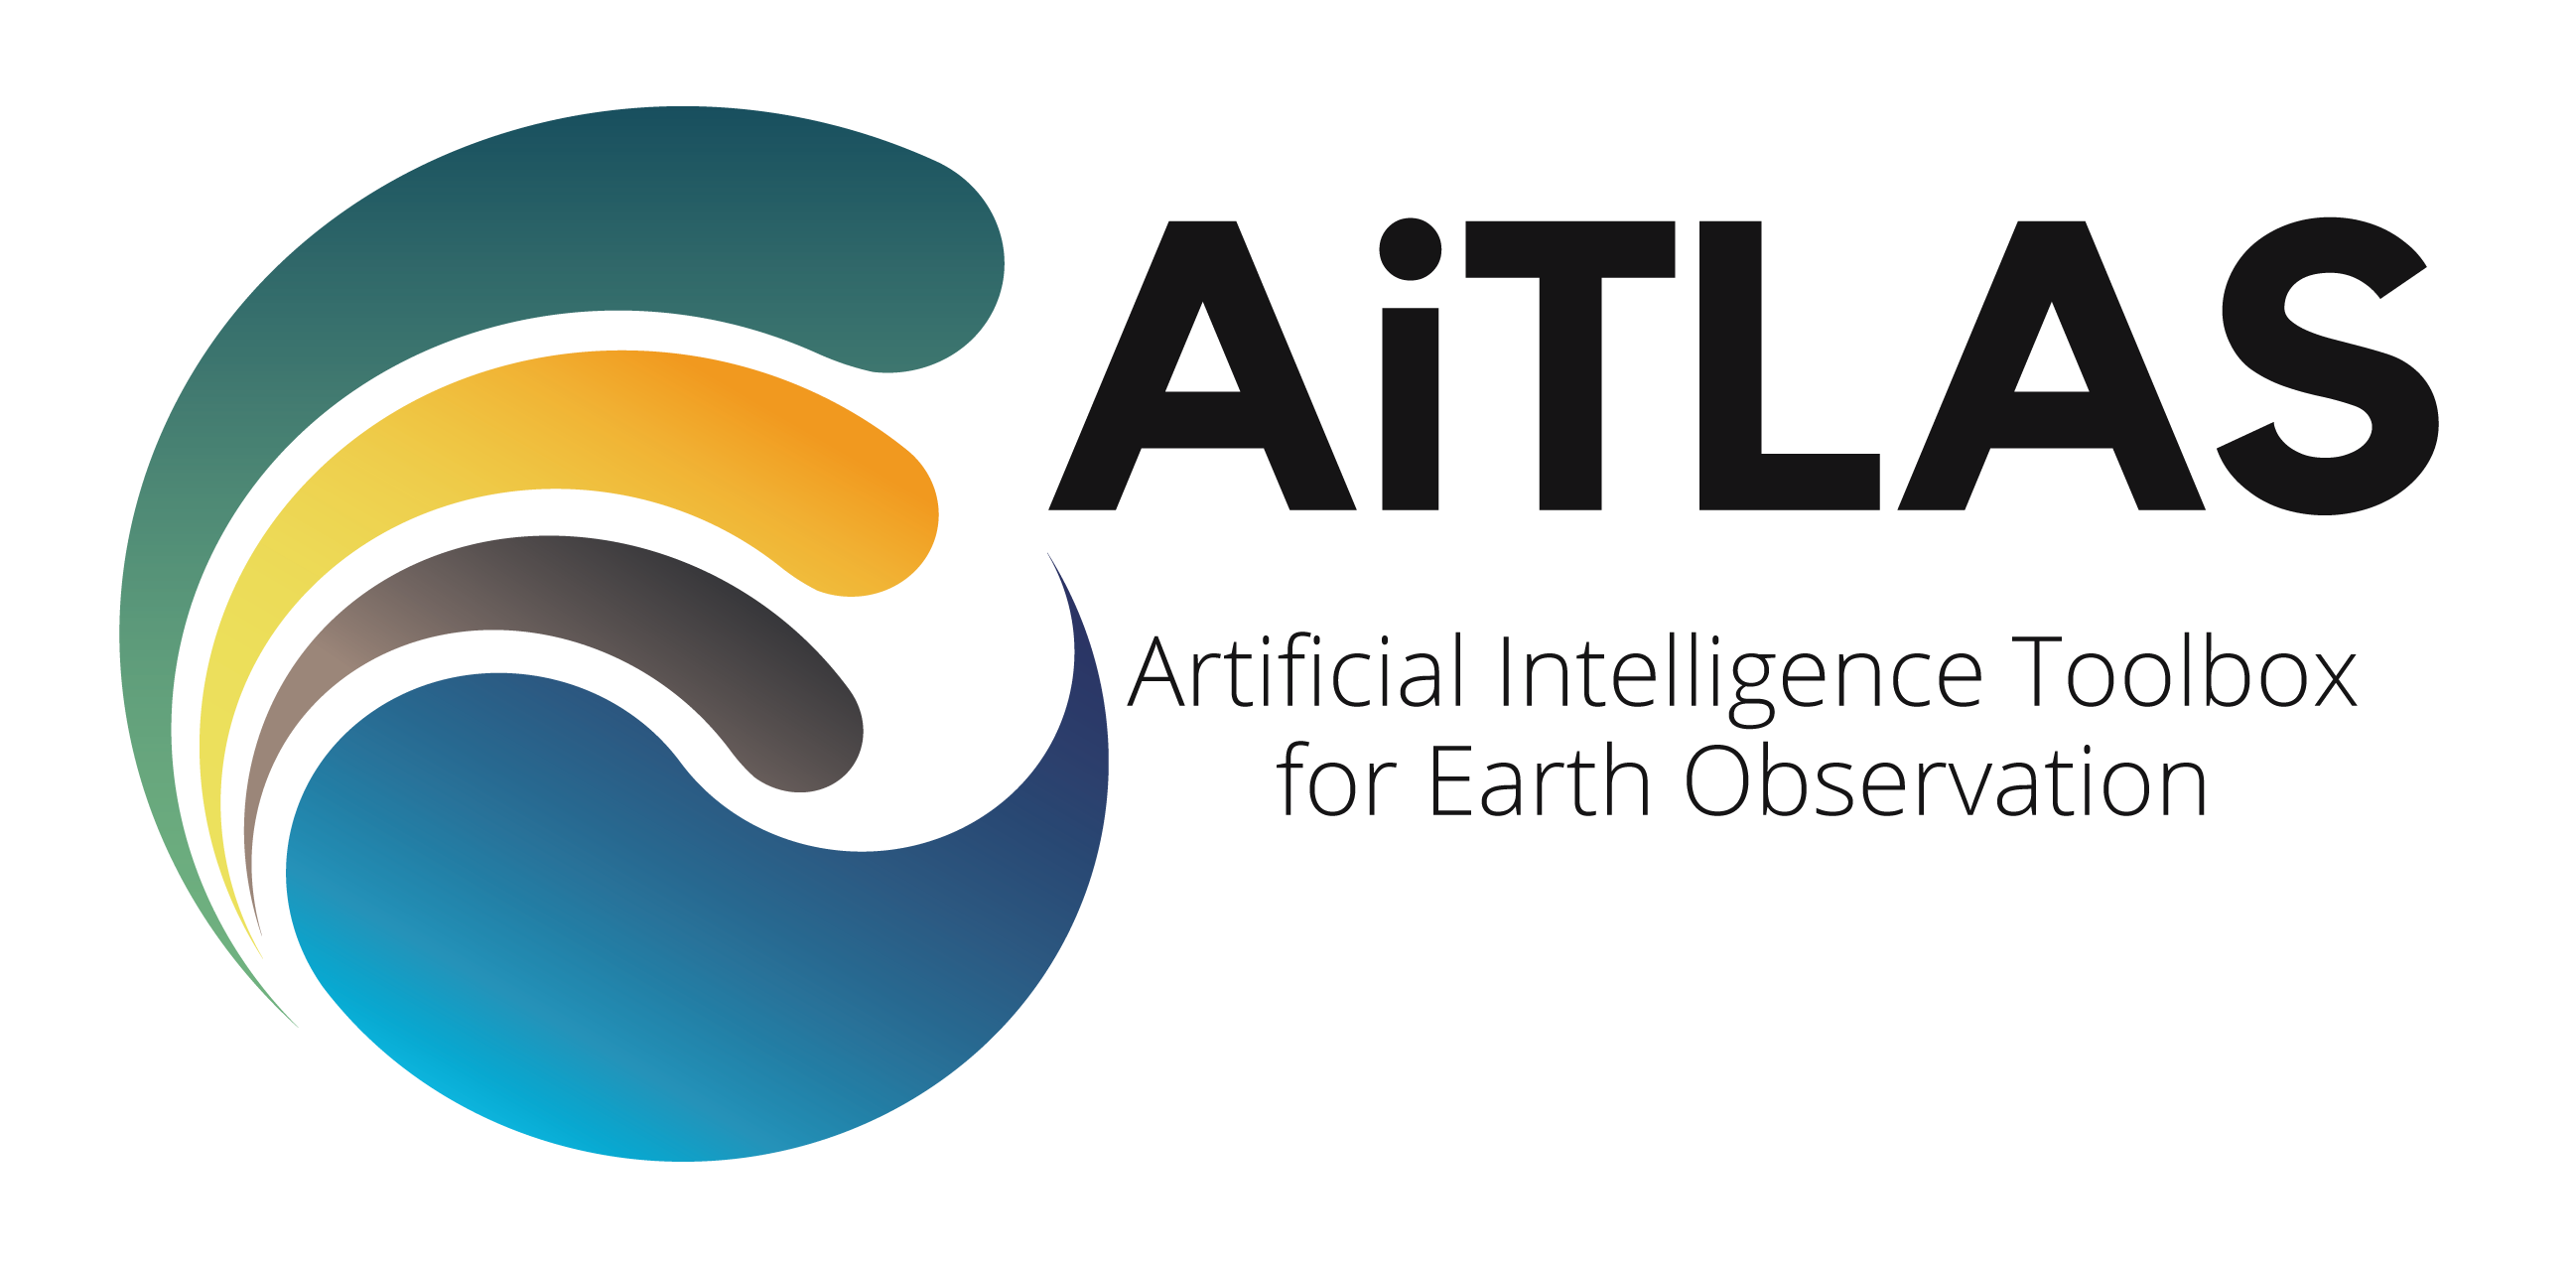

#Introductory Section

##Installing modules

In [1]:
!pip install logging
!pip install munch
!pip install marshmallow
!pip install pytorch-ignite


     |████████████████████████████████| 102kB 7.3MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 225kB 10.6MB/s 


In [2]:
# Эта библиотека нужна для чтения спутниковых снимков -- у них особый формат файла.
!easy_install GDAL

Searching for GDAL
Best match: GDAL 2.2.2
Adding GDAL 2.2.2 to easy-install.pth file

Using /usr/lib/python2.7/dist-packages
Processing dependencies for GDAL
Finished processing dependencies for GDAL


##Loading Libraries

In [3]:
from abc import ABC
from marshmallow import Schema, fields, validate
from munch import Munch
from torchvision import transforms, models
import importlib
import os
from time import time
import numpy as np
import tifffile
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import logging
import torch.optim as optim
import collections
from shutil import copyfile
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from ignite.metrics import confusion_matrix
from ignite.metrics.multilabel_confusion_matrix import MultiLabelConfusionMatrix
import matplotlib.pyplot as plt
from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
from datetime import datetime
from torchvision import transforms as T
import os
from scipy import sparse
from osgeo import gdal, gdal_array
import fastai
import random
import torchvision.transforms.functional as transforms_F
import multiprocessing


##Loading data

Для работы на google colab:
Dataset был доработан для обучения модели на данных лидара



###Google Drive connection

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


###Загрузка трейновых данных

In [ ]:
#!unzip -u '/content/gdrive/MyDrive/train.zip' -d '/content/gdrive/MyDrive/train/'

In [ ]:
!ls /content/gdrive/MyDrive/train # Посмотрим на структуру папки с данными

lidar_train  Sentinel1_train  Sentinel2_train  train_masks


###Загрузка тестовых данных

In [ ]:
#!unzip -u '/content/gdrive/MyDrive/lidar_test.zip' -d '/content/gdrive/MyDrive/test/'

###Проверка загрузки

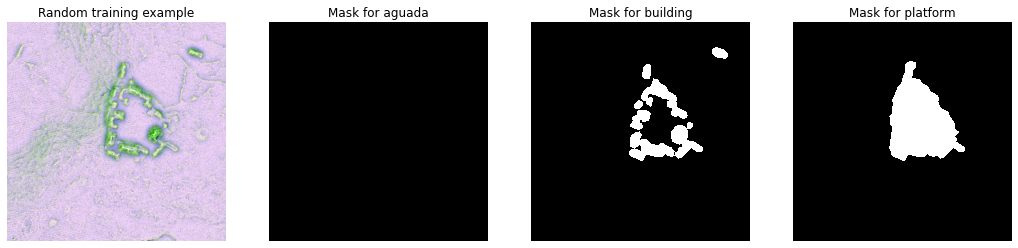

In [ ]:
example_image = Image.open('/content/gdrive/MyDrive/train/lidar_train/tile_359_lidar.tif')
example_mask1 = Image.open('/content/gdrive/MyDrive/train/train_masks/tile_359_mask_aguada.tif')
example_mask2 = Image.open('/content/gdrive/MyDrive/train/train_masks/tile_359_mask_building.tif')
example_mask3 = Image.open('/content/gdrive/MyDrive/train/train_masks/tile_359_mask_platform.tif')

plt.rcParams["figure.figsize"] = (18, 9) # (w, h)
plt.subplot(1,4,1)
plt.imshow(example_image)
plt.title(f"Random training example")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(example_mask1, cmap='gray')
plt.title(f"Mask for aguada")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(example_mask2, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for building")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(example_mask3, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for platform")
plt.axis('off')
plt.show()

##DoDict_Config

In [5]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

config = DotDict()
# with open('./dataset_stats.pickle', 'rb+') as f:
#     config.mean, config.std = pickle.load(f)
# Здесь мы задаем конечный размер картинки, которую выдает нам датасет и которая подается в модель.
# Если вы делаете предсказания не для соревнования, то поставьте здесь 250, тогда размер выходных масок сегментации будет
# 250х250, как и картинка, которая подавалась на вход. 
# Для соревнования размер 480х480
config.resize_min =480
config.resize_max = 480
config.crop_size = 480
config.pretrained = True
config.num_classes = 3#len(ChactunDataset.classes)
config.batch_size = 4
config.epochs = 15
config.lr = 1e-4
config.momentum = 0.9
config.num_workers = multiprocessing.cpu_count()
#экспериметы с добавлением каналов
config.sentinel1_bands = [100, 106, 112, 118, 97, 99, 103, 105]#ascending descending- VV HV mean, std
config.sentinel2_bands = [216, 217, 218, 219]#NIR#[210, 211, 212]# sorted([2 + i for i in range(0, 221, 13)] + [3 + i for i in range(0, 221, 13)] + [4 + i for i in range(0, 221, 13)])#RGB
config.in_chanel = (len(config.sentinel1_bands) + len(config.sentinel2_bands) + 3)
config.pin_memory=True

#Main section

##Utils

In [6]:
def get_class(class_name):
    """returns the class type for a given class name. Expects a string of type `module.submodule.Class`"""
    module = class_name[: class_name.rindex(".")]
    cls = class_name[class_name.rindex(".") + 1:]
    return getattr(importlib.import_module(module), cls)


def current_ts():
    """returns current timestamp in secs"""
    return int(time())


def pil_loader(file, convert_to_grayscale=False):
    """open an image from disk"""
    with open(file, "rb") as f:
        if convert_to_grayscale:
            return np.asarray(Image.open(f).convert('L'))
        return np.asarray(Image.open(f))


def tiff_loader(file):
    """opens a tiff image from disk"""
    return tifffile.imread(file)


def image_loader(file_path, convert_to_grayscale=False):
    filename, file_extension = os.path.splitext(file_path)
    if file_extension in [".jpg", ".png", ".bmp"]:
        return pil_loader(file_path, convert_to_grayscale)
    elif file_extension in [".tif", ".tiff"]:
        return tiff_loader(file_path)
    else:
        raise ValueError(
            "Invalid image. It should be `.jpg, .png, .bmp, .tif, .tiff`"
        )


def image_invert(file_path, convert_to_grayscale=False):
    img = Image.open(file_path).convert('L')
    if convert_to_grayscale:
        img = ImageOps.invert(img)
    return np.asarray(img)


def stringify(obj):
    """stringify whatever object you have"""
    if isinstance(obj, list):
        response = ", ".join([stringify(o) for o in obj])
    elif isinstance(obj, dict):
        response = ", ".join([f"{k}:{stringify(v)}" for k, v in obj.items()])
    else:
        response = str(obj)

    return response


##Metric

###BaseMetric

In [7]:
class BaseMetric:
    """Base class for implementing metrics """

    def __init__(self, device="cpu", **kwargs):
        self.device = device

    def calculate(self, y_true, y_pred):
        raise NotImplementedError("Please implement you metric calculation logic here.")


class RunningScore(object):
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.confusion_matrix = None

    def update(self, y_true, y_pred):
        """Updates stats on each batch"""
        self.confusion_matrix.update((y_pred, y_true))

    def reset(self):
        """Reset the confusion matrix"""
        self.confusion_matrix.reset()

    def get_computed(self):
        return self.confusion_matrix.compute().type(torch.DoubleTensor)

    def precision(self):
        raise NotImplementedError

    def accuracy(self):
        raise NotImplementedError

    def weights(self):
        raise NotImplementedError

    def recall(self):
        raise NotImplementedError

    def f1_score(self):
        precision = self.precision()
        recall = self.recall()
        micro = (
            2
            * precision["Precision Micro"]
            * recall["Recall Micro"]
            / (precision["Precision Micro"] + recall["Recall Micro"])
        )
        per_class = (
            2
            * precision["Precision per Class"]
            * recall["Recall per Class"]
            / (precision["Precision per Class"] + recall["Recall per Class"])
        )

        return {
            "F1_score Micro": float(micro),
            "F1_score Macro": np.mean(per_class),
            "F1_score Weighted": np.sum(self.weights() * per_class),
            "F1_score per Class": per_class.tolist(),
        }

    def iou(self):
        raise NotImplementedError

    def get_scores(self, metrics):
        """Returns the specified metrics"""
        result = []
        for metric in metrics:
            result.append(getattr(self, metric)())
        return result


class MultiClassRunningScore(RunningScore):
    """Calculates confusion matrix for multi-class data. This class contains metrics that are averaged over batches. """

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.confusion_matrix = confusion_matrix.ConfusionMatrix(
            num_classes=num_classes, device=device
        )

    def accuracy(self):
        cm = self.get_computed()
        accuracy = cm.diag().sum() / (cm.sum() + 1e-15)
        return {"Accuracy": accuracy}

    def weights(self):
        cm = self.get_computed()
        return (cm.sum(dim=1) / cm.sum()).numpy()

    def recall(self):
        cm = self.get_computed()
        micro = cm.diag().sum() / (cm.sum() + 1e-15)  # same as accuracy for multiclass
        macro = (cm.diag() / (cm.sum(dim=1) + 1e-15)).mean()
        weighted = (
            (cm.diag() / (cm.sum(dim=1) + 1e-15))
            * ((cm.sum(dim=1)) / (cm.sum() + 1e-15))
        ).sum()
        per_class = cm.diag() / (cm.sum(dim=1) + 1e-15)

        return {
            "Recall Micro": micro,
            "Recall Macro": macro,
            "Recall Weighted": weighted,
            "Recall per Class": per_class.numpy(),
        }

    def precision(self):
        cm = self.get_computed()
        micro = cm.diag().sum() / (cm.sum() + 1e-15)  # same as accuracy for multiclass
        macro = (cm.diag() / (cm.sum(dim=0) + 1e-15)).mean()
        weighted = (
            (cm.diag() / (cm.sum(dim=0) + 1e-15))
            * ((cm.sum(dim=1)) / (cm.sum() + 1e-15))
        ).sum()
        per_class = cm.diag() / (cm.sum(dim=0) + 1e-15)

        return {
            "Precision Micro": micro,
            "Precision Macro": macro,
            "Precision Weighted": weighted,
            "Precision per Class": per_class.numpy(),
        }

    def iou(self):
        cm = self.get_computed()
        iou = cm.diag() / (cm.sum(dim=1) + cm.sum(dim=0) - cm.diag() + 1e-15)

        return {"IOU": iou.tolist(), "mIOU": float(iou.mean())}


class MultiLabelRunningScore(RunningScore):
    """Calculates a confusion matrix for multi-labelled, multi-class data in addition to the """

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.confusion_matrix = MultiLabelConfusionMatrix(
            num_classes=self.num_classes, device=self.device,
        )

    def accuracy(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)

        accuracy = (tp_total + tn_total) / (tp_total + tn_total + fp_total + fn_total)
        accuracy_per_class = (tp + tn) / (tp + tn + fp + fn)

        return {"Accuracy": accuracy, "Accuracy per Class": accuracy_per_class}

    def precision(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)
        micro = tp_total / (tp_total + fp_total)
        per_class = tp / (tp + fp)
        macro = np.mean(per_class)
        weighted = np.sum(per_class * self.weights())
        return {
            "Precision Micro": float(micro),
            "Precision Macro": macro,
            "Precision Weighted": weighted,
            "Precision per Class": per_class,
        }

    def weights(self):
        tp, tn, fp, fn = self.get_outcomes()
        weights = (tp + fn) / self.get_samples()
        return weights

    def recall(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)
        micro = tp_total / (tp_total + fn_total)
        per_class = tp / (tp + fn)
        macro = np.mean(per_class)
        weighted = np.sum(per_class * self.weights())
        return {
            "Recall Micro": float(micro),
            "Recall Macro": macro,
            "Recall Weighted": weighted,
            "Recall per Class": per_class,
        }

    def get_outcomes(self, total=False):
        """
        Return true/false positives/negatives from the confusion matrix
        :param total: do we need to return per class or total
        """
        cm = self.get_computed()
        tp = cm[:, 1, 1]
        tn = cm[:, 0, 0]
        fp = cm[:, 0, 1]
        fn = cm[:, 1, 0]

        if total:  # sum it all if we need to calculate to totals
            tp, tn, fp, fn = tp.sum(), tn.sum(), fp.sum(), fn.sum()

        return tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()

    def count(self):
        tp, tn, fp, fn = self.get_outcomes(True)
        return tp + tn + fp + fn

    def get_samples(self):
        cm = self.confusion_matrix.compute().cpu().detach().numpy()
        return np.sum(cm[:, 1, 0]) + np.sum(cm[:, 1, 1])

    def iou(self):
        tp, tn, fp, fn = self.get_outcomes()
        tp_total, tn_total, fp_total, fn_total = self.get_outcomes(total=True)

        iou_per_class = tp / (tp + fp + fn)
        iou = tp_total / (tp_total + fp_total + fn_total)

        return {
            "IOU": float(iou),
            "IOU mean": np.mean(iou_per_class),
            "IOU per Class": iou_per_class.tolist(),
        }


class SegmentationRunningScore(RunningScore):
    """Calculates a metrics for semantic segmentation"""

    def __init__(self, num_classes, device):
        super().__init__(num_classes, device)
        self.iou_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.f1_score_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.pixel_accuracy_per_class = torch.zeros(num_classes, dtype=torch.float64).to(self.device)
        self.samples = 0

    def update(self, y_true, y_pred):
        """Updates metrics on each batch"""
        num_batches, num_labels, h, w = y_true.shape
        self.samples += num_batches
        for i in range(num_batches):
            for j in range(num_labels):
                intersection = (y_pred[i, j, :, :].unsqueeze(0) & y_true[i, j, :, :].unsqueeze(0)).float().sum(
                    (1, 2))
                union = (y_pred[i, j, :, :].unsqueeze(0) | y_true[i, j, :, :].unsqueeze(0)).float().sum(
                    (1, 2))
                self.iou_per_class[j] += ((intersection + 1e-15) / (union + 1e-15))[0]

    def reset(self):
        """Reset the metrics"""
        self.iou_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.f1_score_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.pixel_accuracy_per_class = torch.zeros(self.num_classes, dtype=torch.float64).to(self.device)
        self.samples = 0

    def iou(self):
        self.iou_per_class = self.iou_per_class / self.samples
        return {
            "IOU mean": float(self.iou_per_class.mean()),
            "IOU per Class": self.iou_per_class.tolist(),
        }


###AccuracyScore

In [8]:
class AccuracyScore(BaseMetric):
    name = "accuracy"
    key = "accuracy"

    def __init__(self, **kwargs):
        BaseMetric.__init__(self, **kwargs)

    def calculate(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)


class AveragedScore(BaseMetric):
    def __init__(self, **kwargs):
        BaseMetric.__init__(self, **kwargs)
        self.method = None

    def calculate(self, y_true, y_pred):
        micro = self.method(y_true, y_pred, average="micro")
        macro = self.method(y_true, y_pred, average="macro")
        weighted = self.method(y_true, y_pred, average="weighted")

        return {"micro": micro, "macro": macro, "weighted": weighted}


class PrecisionScore(AveragedScore):
    name = "precision"
    key = "precision"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = precision_score


class RecallScore(AveragedScore):
    name = "recall"
    key = "recall"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = recall_score


class F1Score(AveragedScore):
    name = "f1 score"
    key = "f1_score"

    def __init__(self, **kwargs):
        AveragedScore.__init__(self, **kwargs)
        self.method = f1_score


##Config

In [9]:
class Config(Munch):
    """ Config object used for automatic object creation from a dict.
    """

    def __init__(self, config):
        def convert(obj):
            """ Recursively convert a dict to Munch. (there is a Munch.from_dict method, but it's not python3 compatible)
            """
            if isinstance(obj, list):
                return [convert(element) for element in obj]
            if isinstance(obj, dict):
                return Munch({k: convert(v) for k, v in obj.items()})
            return obj

        config = convert(config)

        super().__init__(config)


class ObjectConfig(Schema):
    classname = fields.String(required=True, description="Class to instantiate.")
    config = fields.Dict(
        required=True, descripton="Configuration used for instantiation of the class."
    )


class RunConfig(Schema):
    """Top level configuration schema"""

    model = fields.Nested(ObjectConfig, missing=None, description="Model configuration")
    task = fields.Nested(ObjectConfig, required=True, description="Task configuration")


class Configurable(ABC):
    """ Base class for all configurable objects.
    """

    schema = None  # you need specify the schema of the class

    def __init__(self, config):
        if not self.schema:
            raise ValueError(f"You are missing a schema for {self.__class__}")
        self.config = Config(self.schema().load(config))


##DataSet

###BaseDatasetSchema

In [10]:
class BaseDatasetSchema(Schema):
    batch_size = fields.Int(missing=64, description="Batch size", example=64)
    shuffle = fields.Bool(
        missing=True, description="Should shuffle dataset", example=False
    )
    num_workers = fields.Int(missing=4, description="Number of workers", example=4)
    pin_memory = fields.Bool(
        missing=False, description="Whether to use page-locked memory"
    )
    transforms = fields.List(
        fields.String, missing=None, description="Classes to run transformations.",
    )
    target_transforms = fields.List(
        fields.String, missing=None, description="Classes to run transformations.",
    )
    labels = fields.List(
        fields.String, missing=None, description="Labels for the dataset",
    )


class BaseModelSchema(Schema):
    num_classes = fields.Int(missing=2, description="Number of classes", example=2)
    use_cuda = fields.Bool(missing=True, description="Whether to use CUDA if possible")
    metrics = fields.List(
        fields.String,
        missing=["f1_score"],
        description="Metrics you want to calculate",
        example=["accuracy", "precision", "iou"],
        validate=validate.ContainsOnly(
            ["accuracy", "precision", "recall", "f1_score", "iou"]
        ),
    )
    weights = fields.List(
        fields.Float,
        missing=None,
        description="Classes weights you want to apply for the loss",
        example=[1.0, 2.3, 1.0],
    )


class BaseClassifierSchema(BaseModelSchema):
    learning_rate = fields.Float(
        missing=None, description="Learning rate used in training.", example=0.01
    )
    pretrained = fields.Bool(
        missing=True, description="Whether to use a pretrained network or not."
    )
    threshold = fields.Float(
        missing=0.5, description="Prediction threshold if needed", example=0.5
    )


class BaseSegmentationClassifierSchema(BaseClassifierSchema):
    metrics = fields.List(
        fields.String,
        missing=["iou"],
        description="Classes of metrics you want to calculate",
        example=["accuracy", "precision", "recall", "f1_score", "iou"],
    )


class BaseTransformsSchema(Schema):
    pass



###Shemas

In [11]:
class MatDatasetSchema(BaseDatasetSchema):
    mat_file_path = fields.String(
        missing=None, description="mat file on disk", example="./data/dataset.mat",
    )
    mode = fields.String(
        missing='train', description="Which split to use, train or test.", example="train",
    )
    download = fields.Bool(
        missing=False, description="Whether to download the dataset", example=True
    )


class MultiClassClassificationDatasetSchema(BaseDatasetSchema):
    download = fields.Bool(
        missing=False, description="Whether to download the dataset", example=True
    )
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv",
    )


class MultiLabelClassificationDatasetSchema(BaseDatasetSchema):
    root = fields.String(
        missing="/", description="Dataset path on disk", example="./data/BigEarthNet/"
    )

#Применяется эта схема
class SegmentationDatasetSchema(BaseDatasetSchema):
    root = fields.String(
        missing="/", description="Dataset path on disk", example="./data/BigEarthNet/"
    )
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv",
    )


class BigEarthNetSchema(BaseDatasetSchema):
    csv_file_path = fields.String(
        missing=None, description="CSV file on disk", example="./data/train.csv"
    )
    lmdb_path = fields.String(required=True, description="Path to the lmdb storage")
    root = fields.String(
        required=True, description="Dataset path on disk", example="./data/BigEarthNet/"
    )
    import_to_lmdb = fields.Bool(
        missing=False, description="Should the data be moved to LMDB"
    )
    bands10_mean = fields.List(
        fields.Float,
        missing=[429.9430203, 614.21682446, 590.23569706],
        required=False,
        description="List of mean values for the 3 channels",
    )
    bands10_std = fields.List(
        fields.Float,
        missing=[572.41639287, 582.87945694, 675.88746967],
        required=False,
        description="List of std values for the 3 channels",
    )


###BaseTaskShema

In [12]:
class BaseTaskShema(Schema):
    log = fields.Boolean(required=False, missing=True, description="Turn on logging")
    id = fields.String(
        required=False,
        description="Run name/ID",
        example="train_eurosat_123",
        missing=None,
    )


### PredictTaskSchema

In [13]:
class PredictTaskSchema(BaseTaskShema):
    dir = fields.String(
        required=True,
        description="Directory with the image to perform prediction on",
        example="/tmp/test/",
    )
    model_path = fields.String(
        required=True,
        description="Path to the model",
        example="/tmp/model/checkpoint.pth.tar",
    )
    output_path = fields.String(
        missing="predictions.csv",
        description="File or folder path where the csv or plot predictions will be stored",
    )
    dataset_config = fields.Nested(
        missing=None,
        nested=ObjectConfig,
        description="Dataset type and configuration.",
    )
    batch_size = fields.Int(missing=64, description="Batch size", example=64)
    labels = fields.List(
        fields.String, missing=None, description="Labels needed to tag the predictions.",
    )
    transforms = fields.List(
        fields.String,
        missing=[
            "torchvision.transforms.ToPILImage",
            "torchvision.transforms.Resize",
            "torchvision.transforms.CenterCrop",
            "torchvision.transforms.ToTensor",
        ],
        description="Classes to run transformations.",
    )
    output_format = fields.String(
        missing="plot",
        description="Whether to output the predictions to csv or plots",
        validate=validate.OneOf(["plot", "csv", "image"]),
    )

###BaseDataSet

In [14]:
class BaseDataset(Dataset, Configurable):

    schema = BaseDatasetSchema
    labels = None  # need to put the labels here
    name = None

    def __init__(self, config):
        Dataset.__init__(self)
        Configurable.__init__(self, config)

        # get dataloader parameters
        self.shuffle = self.config.shuffle
        self.batch_size = self.config.batch_size
        self.num_workers = self.config.num_workers
        self.pin_memory = self.config.pin_memory

        # get labels if provided in config and not set in class
        if not self.labels and self.config.labels:
            self.labels = self.config.labels

        # get the transformations to be applied for the image and for the target
        self.transform = self.load_transforms(self.config.transforms)
        self.target_transform = self.load_transforms(self.config.target_transforms)

    def __getitem__(self, index):
        """ Implement here what you want to return"""
        raise NotImplementedError(
            "Please implement the `__getittem__` method for your dataset"
        )

    def __len__(self):
        raise NotImplementedError(
            "Please implement the `__len__` method for your dataset"
        )

    def get_name(self):
        if self.name:
            return self.name
        else:
            return ""

    def prepare(self):
        """Implement if something needs to happen to the dataset after object creation"""
        return True

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            # drop_last=True,
        )

    def get_labels(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `labels` method for your dataset"
        )

    def show_batch(self, size):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_batch` method for your dataset"
        )

    def show_samples(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_samples` method for your dataset"
        )

    def show_image(self, index):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `show_image` method for your dataset"
        )

    def data_distribution_table(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `data_distribution_table` method for your dataset"
        )

    def data_distribution_barchart(self):
        """Implement this if you want to return the complete set of labels of the dataset"""
        raise NotImplementedError(
            "Please implement the `data_distribution_barchart` method for your dataset"
        )

    def load_transforms(self, class_names):
        """Loads transformation classes and make a composition of them"""
        return load_transforms(class_names, self.config)


###Новый ChactunDataset

In [15]:
LABELS = ["aguada", "building", "platform"]

default_sentinel1_bands =  [
        97, #mean vv
        99, #std vv
        103, #mean vh
        105 #std vh
    ]
default_sentinel2_bands = [0] 



def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)


class ChactunDataset_new(Dataset):
    labels = LABELS
    classes = ['aguada', 'building', 'platform']
    
    def __init__(self, 
                root_folder, 
                is_train=True, 
                transform=None,
                target_transform=None):
                
        super().__init__()
        

        self.root = Path(root_folder)
        self.type = 'train' if is_train else 'test'
        self.transform = transform        
        self.target_transform = target_transform

        if is_train:
            self.masks_path = self.root / f'{self.type}_masks'
        self.lidar_path = self.root / f'lidar_{self.type}'
        

        self.ids = list(self.gather_complete_tile_ids())

    def gather_complete_tile_ids(self):
        if self.type == 'train':
            masks_ids = gather_tile_ids(self.masks_path)
        lidar_ids = gather_tile_ids(self.lidar_path)
        

        complete_ids = lidar_ids 
        all_ids = lidar_ids 
        if self.type == 'train':
            complete_ids &= masks_ids
            all_ids |= masks_ids

        if len(lidar_ids) < len(all_ids):
            print(f'Lidar images are missing ids: [{all_ids - lidar_ids}]')
        
        
        return complete_ids

    def load_lidar(self, id):
        pil_img = Image.open(self.lidar_path / f'tile_{id}_lidar.tif')
        return T.functional.to_tensor(pil_img)

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=4,
            shuffle=False,
            num_workers=num_workers,#4
            pin_memory=True,
            # drop_last=True,#Раскоментить
        )
            #batch_size=self.batch_size,
            #shuffle=self.shuffle,
            #num_workers=self.num_workers,
            #pin_memory=self.pin_memory,
            # drop_last=True,
        

    

    def load_masks(self, id):
        if self.type == 'test':
            raise NotImplementedError('This dataset is meant for testing and doesn\'t have masks.')
        pil_masks = [np.array(Image.open(self.masks_path / f'tile_{id}_mask_{mask_class}.tif'))
                        for mask_class in self.classes]
        tensor_masks = torch.from_numpy(np.stack(pil_masks)).type(torch.float32) / 255
        # invert masks. Originally 1 = not present, 0 = present
        tensor_masks = 1 - tensor_masks
        return tensor_masks

    def __len__(self):
        return len(self.ids)

    def get_labels(self):
        return self.labels

    def __getitem__(self, i):
        id = self.ids[i]

        x = self.load_lidar(id)
        if self.type == 'train':
            y = self.load_masks(id)
        else:
            y = None

        if self.transform:
            x, y = self.transform(x, y)
        return x, y
    
    
    

class UpsampleSentinelToLidar(object):
    def __call__(self, images, target=None):
        lidar_size = images['lidar'].shape[1:]
        
        merged_image = torch.cat([img_channels for img_channels in images.values() 
                                    if img_channels is not None], dim=0)
        return merged_image, target

###ChactunDataset

In [16]:

default_sentinel1_bands =  [
        97, #mean vv
        99, #std vv
        103, #mean vh
        105, #std vh
    ]
default_sentinel2_bands = [] 



def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)


class ChactunDataset(Dataset):
    
    classes = ['aguada', 'building', 'platform']
    labels = classes
    def __init__(self, 
                root_folder, 
                is_train=True, 
                transform=None,
                sentinel1_bands=None,
                sentinel2_bands=None):
        super().__init__()
        if sentinel1_bands is None:
            sentinel1_bands = default_sentinel1_bands
        if sentinel2_bands is None:
            sentinel2_bands = default_sentinel2_bands
        self.sentinel1_bands = sentinel1_bands
        self.sentinel2_bands = sentinel2_bands

        self.root = Path(root_folder)
        self.type = 'train' if is_train else 'test'
        self.transform = transform
        self.num_bands = 3 + len(sentinel1_bands + sentinel2_bands)

        if is_train:
            self.masks_path = self.root / f'{self.type}_masks'
        self.lidar_path = self.root / f'lidar_{self.type}'
        self.sentinel1_path = self.root / f'Sentinel1_{self.type}'
        self.sentinel2_path = self.root / f'Sentinel2_{self.type}'

        self.ids = list(self.gather_complete_tile_ids())

    def gather_complete_tile_ids(self):
        if self.type == 'train':
            masks_ids = gather_tile_ids(self.masks_path)
        lidar_ids = gather_tile_ids(self.lidar_path)
        sentinel1_ids = gather_tile_ids(self.sentinel1_path)
        sentinel2_ids = gather_tile_ids(self.sentinel2_path)

        complete_ids = lidar_ids & sentinel1_ids & sentinel2_ids
        all_ids = lidar_ids | sentinel1_ids | sentinel2_ids
        if self.type == 'train':
            complete_ids &= masks_ids
            all_ids |= masks_ids

        if len(lidar_ids) < len(all_ids):
            print(f'Lidar images are missing ids: [{all_ids - lidar_ids}]')
        if len(sentinel1_ids) < len(all_ids):
            print(f'Sentinel1 images are missing ids: [{all_ids - sentinel1_ids}]')
        if len(sentinel2_ids) < len(all_ids):
            print(f'Sentinel2 images are missing ids: [{all_ids - sentinel2_ids}]')
        
        return complete_ids

    def load_lidar(self, id):
        pil_img = Image.open(self.lidar_path / f'tile_{id}_lidar.tif')
        return T.functional.to_tensor(pil_img)

    def load_sentinel1(self, id):
        if len(self.sentinel1_bands) == 0:
            return None
            
        img = gdal_array.LoadFile(str(self.sentinel1_path / f'tile_{id}_S1.tiff'))
        return torch.from_numpy(img)[self.sentinel1_bands]

    def load_sentinel2(self, id):
        if len(self.sentinel2_bands) == 0:
            return None

        img = gdal_array.LoadFile(str(self.sentinel2_path / f'tile_{id}_S2.tiff'))
        return torch.from_numpy(img)[self.sentinel2_bands]

    def load_masks(self, id):
        if self.type == 'test':
            raise NotImplementedError('This dataset is meant for testing and doesn\'t have masks.')
        pil_masks = [np.array(Image.open(self.masks_path / f'tile_{id}_mask_{mask_class}.tif'))
                        for mask_class in self.classes]
        tensor_masks = torch.from_numpy(np.stack(pil_masks)).type(torch.float32) / 255
        # invert masks. Originally 1 = not present, 0 = present
        tensor_masks = 1 - tensor_masks
        return tensor_masks

    def __len__(self):
        return len(self.ids)

    def dataloader(self):
        return torch.utils.data.DataLoader(
            self,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=config.num_workers,
            pin_memory=config.pin_memory,
            drop_last=True,
        )

    def get_labels(self):
        return self.labels

    def __getitem__(self, i):
        id = self.ids[i]

        x = {'lidar': self.load_lidar(id), 
             'sentinel1': self.load_sentinel1(id), 
             'sentinel2': self.load_sentinel2(id)}
        if self.type == 'train':
            y = self.load_masks(id)
        else:
            y = 0####none

        if self.transform:
            x, y = self.transform(x, y)
      
        return x, y


class UpsampleSentinelToLidar(object):
    def __call__(self, images, target=None):
        lidar_size = images['lidar'].shape[1:]

        if images['sentinel1'] is not None:
            images['sentinel1'] = T.functional.resize(images['sentinel1'], lidar_size,
                                                  interpolation=Image.BILINEAR)#
        if images['sentinel2'] is not None:
            images['sentinel2'] = T.functional.resize(images['sentinel2'], lidar_size,
                                                  interpolation=Image.BILINEAR)#
        
        merged_image = torch.cat([img_channels for img_channels in images.values() 
                                    if img_channels is not None], dim=0)
        return merged_image, target

### BaseTask

In [17]:
class BaseTask(Configurable):
    def __init__(self, model, config):
        super().__init__(config)

        self.model = model

        # generate a task ID if not specified
        id = self.config.id
        if not id:
            id = str(self.generate_task_id())
        self.id = id

    @staticmethod
    def create_dataset(dataset_config):
        """ Builds the input dataset using the provided configuration. """

        classname, config = dataset_config.classname, dataset_config.config

        cls = get_class(classname)
        if not issubclass(cls, BaseDataset):
            raise ValueError("Data input class does not inherit from BaseInput.")

        dataset = cls(config)

        return dataset

    def generate_task_id(self):
        """Generates a task ID"""
        return current_ts()

    def run(self):
        """Runs the task."""
        raise NotImplementedError


##Transform

###Load_transforms

In [18]:
TRANSFORMS_PARAMS = {
    "torchvision.transforms.Resize": 256,
    "torchvision.transforms.CenterCrop": 224,
}


def load_transforms(class_names, config):
    """Loads transformation classes and make a composition of them"""
    lst_transforms = []

    if not class_names:
        return None

    # check all transformation classes
    for name in class_names:
        cls = get_class(name)  # get class
        args = TRANSFORMS_PARAMS.get(name, None)  # get params, if specified
        if args:
            transfrm = cls(args)
        else:
            if getattr(cls, "configurables", None):
                kwargs = {}
                for key in cls.configurables:
                    kwargs[key] = getattr(config, key)
                transfrm = cls(**kwargs)
            else:
                transfrm = cls()

        lst_transforms.append(transfrm)

    # return as composition
    return transforms.Compose(lst_transforms)


class BaseTransforms(object):
    """Base class for implementing configurable transformations"""

    schema = BaseTransformsSchema

    configurables = None

    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, sample):
        raise NotImplementedError("Please implement the `__call__` method")


###NormalizeRGB

In [19]:
class NormalizeRGB(BaseTransforms):

    configurables = ["bands10_mean", "bands10_std"]

    def __init__(self, *args, **kwargs):
        BaseTransforms.__init__(self, *args, **kwargs)

        self.bands10_mean = kwargs["bands10_mean"]
        self.bands10_std = kwargs["bands10_std"]

    def __call__(self, input, target=None):
        bands10, multihots = input

        for t, m, s in zip(bands10, self.bands10_mean, self.bands10_std):
            t.sub_(m).div_(s)

        return bands10, multihots


class ToTensorRGB(BaseTransforms):
    def __call__(self, input, target=None):
        bands10, multihots = input
        return torch.tensor(bands10), multihots


class NormalizeAllBands(BaseTransforms):

    configurables = ["bands10_mean", "bands10_std", "bands20_mean", "bands20_std"]

    def __init__(self, *args, **kwargs):
        BaseTransforms.__init__(self, *args, **kwargs)

        self.bands10_mean = kwargs["bands10_mean"]
        self.bands10_std = kwargs["bands10_std"]
        self.bands20_mean = kwargs["bands20_mean"]
        self.bands20_std = kwargs["bands20_std"]

    def __call__(self, input, target=None):
        bands10, bands20, multihots = input

        for t, m, s in zip(bands10, self.bands10_mean, self.bands10_std):
            t.sub_(m).div_(s)

        for t, m, s in zip(bands20, self.bands20_mean, self.bands20_std):
            t.sub_(m).div_(s)

        return bands10, bands20, multihots


class ToTensorAllBands(BaseTransforms):
    def __call__(self, input, target=None):
        bands10, bands20, multihots = input
        return torch.tensor(bands10), torch.tensor(bands20), multihots


###ResizeCenterCropFlipHVToTensor
    

In [20]:
class ResizeCenterCropFlipHVToTensor(BaseTransforms):
    def __call__(self, sample):
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ])

        return data_transforms(sample)
class ResizeCenterCropToTensor(BaseTransforms):
    def __call__(self, sample):
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        return data_transforms(sample)

###Segmentation

In [21]:
class MinMaxNormTransponse(BaseTransforms):
    def __call__(self, sample):
        return sample.transpose(2, 0, 1).astype("float32") / 255


class Transponse(BaseTransforms):
    def __call__(self, sample):
        return sample.transpose(2, 0, 1).astype("float32")


class MinMaxNorm(BaseTransforms):
    def __call__(self, sample):
        return sample.astype("float32") / 255

###Transformation

In [22]:
def pad_if_smaller(img, size, fill=0):
    min_size = min(img.shape[1:])
    if min_size < size:
        ow, oh = img.size
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = F.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        size = random.randint(self.min_size, self.max_size)
        image = transforms_F.resize(image, size)
        if target is not None:
            target = transforms_F.resize(target, size, interpolation=Image.NEAREST)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = transforms_F.hflip(image)
            if target is not None:
                target = transforms_F.hflip(target)
        return image, target


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = pad_if_smaller(image, self.size)
        target = pad_if_smaller(target, self.size, fill=255)
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        image = transforms_F.crop(image, *crop_params)
        if target is not None:
            target = transforms_F.crop(target, *crop_params)
        return image, target


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = transforms_F.center_crop(image, self.size)
        if target is not None:
            target = transforms_F.center_crop(target, self.size)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        if target is not None:
            target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = transforms_F.normalize(image, mean=self.mean, std=self.std)
        return image, target

##Визуализация

###BaseDetailedVisualization

In [23]:
class BaseVisualization:
    """Base class for visualizations"""

    def __init__(self, cm, labels, file, **kwargs):
        """Get default params"""
        self.cm = cm
        self.labels = labels
        self.output_file = file

    def plot(self):
        raise NotImplementedError("Please implement the `plot` method.")


class BaseDetailedVisualization(BaseVisualization):
    """Base class for visualizations"""

    def __init__(self, y_true, y_pred, y_prob, labels, file, **kwargs):
        """Get default params"""
        super().__init__(None, labels, file, **kwargs)

        self.y_true = y_true
        self.y_pred = y_pred
        self.y_prob = y_prob

    def plot(self):
        raise NotImplementedError("Please implement the `plot` method.")


###ImageMaskPredictionVisualization

In [24]:
class ImageMaskPredictionVisualization(BaseDetailedVisualization):
    def __init__(self, y_true, y_pred, y_prob, labels, file, **kwargs):###
        super().__init__(y_true, y_pred, y_prob, labels, file, **kwargs)
        self.image = kwargs.get("image")
        
    def plot(self):
        image = pil_loader(self.image)
        fig = self.plot_segmenation(image, self.y_prob, self.labels)
        fig.savefig(self.output_file, format="png")

    def plot_segmenation(self, img, probs, labels):
        """Display image and preditions from model"""

        # Show the image
        fig = plt.figure(figsize=(10, 10))

        # plot image
        plt.subplot(1, len(labels) + 1, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")
        
        

        # plot masks
        for i in range(len(probs)):
            plt.subplot(1, len(labels) + 1, i + 2)
            plt.imshow(probs[i])
            plt.title(labels[i])
            plt.axis("off")

        plt.tight_layout()

        return fig


def display_image_segmentation(image, y_true, y_pred, y_prob, labels, file):###
    viz = ImageMaskPredictionVisualization(
        y_true, y_pred, y_prob, labels, file, image=image
    )
    viz.plot()


def save_predicted_masks(y_pred, labels, base_filepath_name):
    # save predicted masks
    for i in range(len(labels)):
        mask = Image.fromarray(y_pred[i].astype(np.uint8)*255)
        mask = ImageOps.invert(mask)
        mask.save("{}_{}.png".format(base_filepath_name, labels[i]))


##Оптимизаторы

In [25]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, logits, targets):
        
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        
        EPSILON = 1e-7
        
        # Flattening the final layer 
        preds_flat = preds.view(N,-1)
        targets_flat = targets.view(N, -1)
        
        intersection = (preds_flat * targets_flat).sum()
        union = (preds_flat + targets_flat).sum()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

##Модель

###BaseModel

определение batch_size и коэффициента разделения датасета

In [26]:
#for i in range(1, 441):
 # for j in range(4, 34):
  #  if (1764 - i) % j == 0 and i % j == 0 and ((1 - (1764 - i) / 1764) < 0.35 and (1 - ((1764 - i) / 1764) > 0.1)):
  #    print(f'train: {(1764 - i)}, test: {i}, batch_size: {j} coefc: {round(1 - (1764 - i) / 1764, 3)}')


In [27]:
class BaseModel(nn.Module, Configurable):

    schema = BaseModelSchema

    def __init__(self, config=None):
        Configurable.__init__(self, config)
        super(BaseModel, self).__init__()

        self.model = nn.Module()

        device_name = "cpu"
        if self.config.use_cuda and torch.cuda.is_available():
            device_name = "cuda"

        self.device = torch.device(device_name)

        self.metrics = self.config.metrics
        self.num_classes = self.config.num_classes
        self.running_metrics = RunningScore(self.num_classes, self.device)
        self.weights = self.config.weights

    def prepare(self):
        """Prepare the model before using it """

        # load loss, optimizer and lr scheduler
        self.criterion = self.load_criterion()
        self.optimizer = self.load_optimizer()
        self.lr_scheduler = self.load_lr_scheduler()

    def fit(
        self,
        dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,#BaseDataset = None
        run_id: str = None,
        **kwargs,
    ):
        logging.info("Starting training.")

        start_epoch = 0
        start = current_ts()

        # load the model if needs to resume training
        if resume_model:
            start_epoch, loss, start, run_id = self.load_model(
                resume_model, self.optimizer
            )

        # allocate device
        self.allocate_device()

        # start logger
        self.writer = SummaryWriter(os.path.join(model_directory, run_id))

        
        # get data loaders
        train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#изменить при работе с DLS
        val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#Noneизменить при работе с DLS
        if val_ds:#val_dataset:
            val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)#DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)#4изменить при работе с DLS

        for epoch in range(start_epoch, epochs):  # loop over the dataset multiple times
            loss = self.train_epoch(
                epoch, train_loader, self.optimizer, self.criterion, iterations_log
            )
            self.writer.add_scalar("Loss/train", loss, epoch + 1)
            if epoch % save_epochs == 0:
                self.save_model(
                    model_directory, epoch, self.optimizer, loss, start, run_id
                )
##Scheduler
            # adjust learning rate if needed
            if self.lr_scheduler:
               self.lr_scheduler.step()

            # evaluate against the train set
            train_loss = self.evaluate_model(
                train_loader,
                criterion=self.criterion,
                description="testing on train set",
            )
            self.log_metrics(
                self.running_metrics.get_scores(self.metrics),
                dataset.dataset.get_labels(),####dataset.
                "train",
                self.writer,
                epoch + 1,
            )
           #wandb.log()#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            self.running_metrics.reset()

            # evaluate against a validation set if there is one
            if val_loader:
                val_loss = self.evaluate_model(
                    val_loader,
                    criterion=self.criterion,
                    description="testing on validation set",
                )
                self.log_metrics(
                    self.running_metrics.get_scores(self.metrics),
                    dataset.dataset.get_labels(),####dataset.
                    "val",
                    self.writer,
                    epoch + 1,
                )
                self.writer.add_scalar("Loss/val", val_loss, epoch + 1)
                self.running_metrics.reset()
                ####
           
            

        self.writer.close()

        # save the model in the end
        self.save_model(model_directory, epochs, self.optimizer, loss, start, run_id)

        logging.info(f"finished training. training time: {current_ts() - start}")

    def train_epoch(self, epoch, dataloader, optimizer, criterion, iterations_log):
        start = current_ts()
        running_loss = 0.0
        total_loss = 0.0

        self.model.train()
        for i, data in enumerate(tqdm(dataloader, desc="training")):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # zero the parameter gradients
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.zero_grad()
            else:
                optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self(inputs)

            # check if outputs is OrderedDict for segmentation
            if isinstance(outputs, collections.Mapping):
                outputs = outputs["out"]

            loss = criterion(
                outputs, labels if len(labels.shape) == 1 else labels.type(torch.float)
            )  # TODO: Check this converion OUT!!!
            loss.backward()

            # perform a single optimization step
            if isinstance(optimizer, tuple):
                for opt in optimizer:
                    opt.step()
            else:
                optimizer.step()

            # log statistics
            running_loss += loss.item() * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)

            if (
                i % iterations_log == iterations_log - 1
            ):  # print every iterations_log mini-batches
                logging.info(
                    f"[{epoch + 1}, {i + 1}], loss: {running_loss / iterations_log : .5f}"
                )
                #wandb.log({"loss": (running_loss / iterations_log)})
                running_loss = 0.0
        
        total_loss = total_loss / len(dataloader.dataset)
        #wandb.log({'loss': total_loss})
        logging.info(
            f"epoch: {epoch + 1}, time: {current_ts() - start}, loss: {total_loss: .5f}"
        )
        return total_loss

    def evaluate(
        self, dataset: BaseDataset = None, model_path: str = None,
    ):
        """
        Evaluate a model stored in a specified path against a given dataset

        :param dataset: the dataset to evaluate against
        :param model_path: the path to the model on disk
        :return:
        """
        # load the model
        self.load_model(model_path)

        # get test data loader
        
        dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)#4

        # evaluate model on data
        result = self.evaluate_model(dataloader, description="testing on test set")
        #wandb.log(result)####
        return result

    def evaluate_model(
        self, dataloader, criterion=None, description="testing on validation set",
    ):
        """
        Evaluates the current model against the specified dataloader for the specified metrics
        :param dataloader:
        :param metrics: list of metric keys to calculate
        :criterion: Criterion to calculate loss
        :description: What to show in the progress bar
        :return: tuple of (metrics, y_true, y_pred)
        """
        self.model.eval()

        # initialize loss if applicable
        total_loss = 0.0

        for inputs, outputs, labels in self.predict_output_per_batch(
            dataloader, description
        ):
            if criterion:
                batch_loss = criterion(outputs, labels)
                total_loss += batch_loss.item() * inputs.size(0)

            predicted_probs, predicted = self.get_predicted(outputs)

            if (
                len(labels.shape) == 1
            ):  # if it is multiclass, then we need one hot encoding for the predictions
                one_hot = torch.zeros(labels.size(0), self.num_classes)
                predicted = predicted.reshape(predicted.size(0))
                one_hot[torch.arange(labels.size(0)), predicted.type(torch.long)] = 1
                predicted = one_hot
                predicted = predicted.to(self.device)

            self.running_metrics.update(
                labels.type(torch.int64), predicted.type(torch.int64)
            )

        if criterion:
            total_loss = total_loss / len(dataloader.dataset)

        return total_loss

    def predict(
        self, dataset: BaseDataset = None, description="running prediction",
    ):
        """
        Predicts using a model against for a specified dataset

        :return: tuple of (y_true, y_pred, y_pred_probs)
        """
        # initialize counters
        y_true = []
        y_pred = []
        y_pred_probs = []
        dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)
        # predict
        for inputs, outputs, labels in self.predict_output_per_batch(
            dataloader, description            
        ):
        
            predicted_probs, predicted = self.get_predicted(outputs)
            y_pred_probs += list(predicted_probs.cpu().detach().numpy())
            y_pred += list(predicted.cpu().detach().numpy())
            y_true += list(labels.cpu().detach().numpy())

        return y_true, y_pred, y_pred_probs

   

    def predict_image(
        self,
        image=None,
        data_transforms=None,
        description="running prediction for single image",
    ):
        """
        Predicts using a model against for a specified image

        :return: tuple of (y_true, y_pred, y_pred_probs)
        """
        # load the image and apply transformations, if transforms in None convert only to Tensor
        self.model.eval()
        if data_transforms:
            image = data_transforms(image)
        else:
            data_transforms = transforms.Compose([transforms.ToTensor(),])
            image = data_transforms(image)
        # convert to batch of size 1
        inputs = image.unsqueeze(0).to(self.device)
        outputs = self(inputs)
        # check if outputs is OrderedDict for segmentation
        if isinstance(outputs, collections.Mapping):
            outputs = outputs["out"]

        predicted_probs, predicted = self.get_predicted(outputs)
        y_pred_probs = list(predicted_probs.cpu().detach().numpy())
        y_pred = list(predicted.cpu().detach().numpy())
        y_true = None

        return y_true, y_pred, y_pred_probs

    def predict_output_per_batch(self, dataloader, description):
        """Run predictions on a dataloader and return inputs, outputs, labels per batch"""

        # turn on eval mode
        self.model.eval()
        #dataset = test_ds# при тренировке
        #dataset = val_ds# при обучении
        #dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)#########
        # run predictions
        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc=description)):
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)

                # check if outputs is OrderedDict for segmentation
                if isinstance(outputs, collections.Mapping):
                    outputs = outputs["out"]

                yield inputs, outputs, labels
    def predict_output_npz(self, dataloader, description):
        """Run predictions on a dataloader and return inputs, outputs, labels per batch"""

        # turn on eval mode
        self.model.eval()

        # run predictions
        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc=description)):
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)

                # check if outputs is OrderedDict for segmentation
                if isinstance(outputs, collections.Mapping):
                    outputs = outputs["out"]

                yield inputs, outputs, labels

    def forward(self, *input, **kwargs):
        """
        Abstract method implementing the model. Extending classes should override this method.
        :return:  instance extending `nn.Module`
        """
        raise NotImplementedError

    def get_predicted(self, outputs, threshold=None):
        """Gets the output from the model and return the predictions
        :return: tuple in the format (probabilities, predicted classes/labels)
        """
        raise NotImplementedError("Please implement `get_predicted` for your model. ")

    def report(self, labels, dataset_name, running_metrics, **kwargs):
        """The report we want to generate for the model"""
        return ()

    def log_metrics(self, output, labels, tag="train", writer=None, epoch=0):
        """Log the calculated metrics"""
        calculated_metrics = output
        logging.info(stringify(calculated_metrics))
        if writer:
            for cm in calculated_metrics:
                for key in cm:
                    metric = cm[key]
                    if isinstance(metric, list) or isinstance(metric, np.ndarray):
                        for i, sub in enumerate(metric):
                            writer.add_scalar(f"{key}/{labels[i]}/{tag}", sub, epoch)
                    else:
                        writer.add_scalar(f"{key}/{tag}", metric, epoch)

    def allocate_device(self, opts=None):
        """
        Put the model on CPU or GPU
        :return:
        """
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        self.model = self.model.to(self.device)
        return self.model

    def save_model(self, model_directory, epoch, optimizer, loss, start, run_id):
        """
        Saves the model on disk
        :param model_directory:
        :return:
        """
        if not os.path.isdir(model_directory):
            os.makedirs(model_directory)

        if not os.path.isdir(os.path.join(model_directory, run_id)):
            os.makedirs(os.path.join(model_directory, run_id))

        timestamp = current_ts()
        checkpoint = os.path.join(
            model_directory, run_id, f"checkpoint_{timestamp}.pth.tar"
        )

        # create timestamped checkpoint
        torch.save(
            {
                "epoch": epoch + 1,
                "state_dict": self.model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "start": start,
                "id": run_id,
            },
            checkpoint,
        )

        # replace last checkpoint
        copyfile(checkpoint, os.path.join(model_directory, "checkpoint.pth.tar"))

    def extract_features(self, *input, **kwargs):
        """
        Abstract for trim the model to extract feature. Extending classes should override this method.
        """
        return self.model

    def load_model(self, file_path, optimizer=None):
        """Loads a model from a checkpoint"""
        if os.path.isfile(file_path):
            logging.info(f"Loading checkpoint {file_path}")
            checkpoint = torch.load(file_path)

            if "state_dict" in checkpoint:
                self.model.load_state_dict(checkpoint["state_dict"], strict=False)
                self.allocate_device()

                start_epoch = checkpoint["epoch"]
                loss = checkpoint["loss"]
                start = checkpoint["start"]
                run_id = checkpoint["id"]
            else:
                self.model.load_state_dict(checkpoint)
                self.allocate_device()

                start_epoch = 1
                loss = 0
                start = 0
                run_id = ""

            if optimizer:
                optimizer.load_state_dict(checkpoint["optimizer"])

            logging.info(f"Loaded checkpoint {file_path} at epoch {start_epoch}")
            return (start_epoch, loss, start, run_id)
        else:
            raise ValueError(f"No checkpoint found at {file_path}")

    def load_optimizer(self):
        """Load the optimizer"""
        raise NotImplementedError("Please implement `load_optimizer` for your model. ")

    def load_criterion(self):
        """Load the loss function"""
        raise NotImplementedError("Please implement `load_criterion` for your model. ")

    def load_lr_scheduler(self):
        raise NotImplementedError(
            "Please implement `load_lr_scheduler` for your model. "
        )

    def train_model(
        self,
        train_dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,
        run_id: str = None,
        **kwargs,
    ):
        return self.fit(
            dataset=train_dataset,
            epochs=epochs,
            model_directory=model_directory,
            save_epochs=save_epochs,
            iterations_log=iterations_log,
            resume_model=resume_model,
            run_id=run_id,
            **kwargs,
        )

    def train_and_evaluate_model(
        self,
        train_dataset: BaseDataset,
        epochs: int = 100,
        model_directory: str = None,
        save_epochs: int = 10,
        iterations_log: int = 100,
        resume_model: str = None,
        val_dataset: BaseDataset = None,
        run_id: str = None,
        **kwargs,
    ):
        return self.fit(
            dataset=train_data,
            epochs=epochs,
            model_directory=model_directory,
            save_epochs=save_epochs,
            iterations_log=iterations_log,
            resume_model=resume_model,
            val_dataset=val_dataset,
            run_id=run_id,
            **kwargs,
        )

###ImageFolderDataset

In [28]:
def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)

class ImageFolderDataset(BaseDataset):
    def __init__(self, root, labels, transforms, batch_size):
        BaseDataset.__init__(self, {})

        self.root = root
        self.labels = labels
        self.transform = transforms
        #self.transform = self.load_transforms(transforms)
        self.shuffle = False
        self.batch_size = batch_size

        self.data = []
        self.fnames = []
        self.ids = []
        #self.lidar_path = self.root / f'lidar_'###
        #self.ids = list(gather_tile_ids(fnamesh))###

        def gather_complete_tile_ids(self):###
            lidar_ids = gather_tile_ids(self.lidar_path)###

        dir = os.path.expanduser(self.root)
        for root, _, fnames in sorted(os.walk(dir)):
            for fname in sorted(fnames):
                self.data.append(os.path.join(root, fname))
                self.fnames.append(fname)
                self.ids.append(int(fname.split('_')[1]))
                
    def __getitem__(self, index):
        img = self.data[index]
        return (
            #self.transform(image_loader(img)),
            self.transform(image_loader(img)),
            0,
        )  # returning `0` because we have no target

    def __len__(self):
        return len(self.data)


class PredictTask(BaseTask):
    schema = PredictTaskSchema

    def __init__(self, model: BaseModel, config):
        super().__init__(model, config)

        self.dir = self.config.dir
        self.output_path = self.config.output_path
        self.output_format = self.config.output_format

    def run(self):
        """Do something awesome here"""


###BaseSegmentationClassifier

Здесь мы меняем оптимизаторы, функцию потерь, scheduler, эксперименты проводились в конфигурациях:
1. optim.Adam + nn.MSELoss;#Базовые настройки 25 epoch + randomflip 
> IOU_Mean:0.767 iou_aguada: 0.979, iou_building: 0.661, iou_platform: 0.666
2. optim.AdamW + Focal Loss;#Не заработало
3. optim.AdamW + Focal Loss + scheduler#Не заработало
4. optim.SGD + nn.MSELoss#Работает  15 epoch + randomflip
> IOU: 0.622284 IOU-a: 0.963415 IOU-p: 0.480418 IOU-b: 0.423019
5. optim.Adam + nn.MSELoss;#Базовые настройки 30 epoch + randomflip + 0.404treshold
> IOU_Mean:0.780 iou_aguada: 0.984, iou_building: 0.681, iou_platform: 0.677






In [29]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


class BaseSegmentationClassifier(BaseModel):

    schema = BaseSegmentationClassifierSchema

    def __init__(self, config):
        super().__init__(config)

        self.running_metrics = SegmentationRunningScore(self.num_classes, self.device)

    def get_predicted(self, outputs, threshold=None):
        predicted_probs = torch.tanh(outputs)
        predicted = (predicted_probs >= self.config.threshold).type(
            predicted_probs.dtype
        )
        return predicted_probs, predicted

    def load_optimizer(self):
        """Load the optimizer"""
        return optim.Adam(self.model.parameters())#optim.SGD(self.model.parameters(), lr=self.config.learning_rate, momentum=0.9)#optim.Adam(self.model.parameters())#, lr=self.config.learning_rate, momentum=0.9)#optim.AdamW([dict(params=self.model.parameters(), lr=self.config.learning_rate), ])# 
        #optim.SGD(self.model.parameters(), lrself.config.learning_rate, momentum=0.9)#optim.AdamW(self.model.parameters(), lr=0.0001, eps=1e-08, weight_decay=0.05, amsgrad=False)####Попродовать optimizer

    def load_criterion(self):
        """Load the loss function"""
        return nn.MSELoss(reduction="mean")#nn.BCELoss(reduction="mean")#nn.MSELoss(reduction="mean")###Попродовать поменять лосс функц nn.BCELoss()

    def load_lr_scheduler(self):
        return None#optim.lr_scheduler.OneCycleLR(self.optimizer, self.config.learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))
        #optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min'),#None#optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[30,60], gamma=0.8)#None###Попродовать поменять sceduler ReduceLROnPlateau
        

In [30]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


class BaseSegmentationClassifier(BaseModel):

    schema = BaseSegmentationClassifierSchema

    def __init__(self, config):
        super().__init__(config)

        self.running_metrics = SegmentationRunningScore(self.num_classes, self.device)

    def get_predicted(self, outputs, threshold=None):
        predicted_probs = torch.tanh(outputs)
        predicted = (predicted_probs >= self.config.threshold).type(
            predicted_probs.dtype
        )
        return predicted_probs, predicted

    def load_optimizer(self):
        """Load the optimizer"""
        return optim.Adam([dict(params=self.model.parameters(), lr=self.config.learning_rate), ])

    def load_criterion(self):
        """Load the loss function"""
        return nn.MSELoss(reduction="mean")###Попродовать поменять лосс функц

    def load_lr_scheduler(self):
        return None


###DeeplabV3

In [31]:
in_chanel = config.in_chanel
class DeepLabV3(BaseSegmentationClassifier):
    def __init__(self, config):
        BaseSegmentationClassifier.__init__(self, config)

        self.model = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True
        )
        # change first layer to work with different number of classes
        
        self.model.backbone.conv1 = nn.Conv2d(in_chanel , 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#меняем колличество входных каналов
        #self.model.backbone.conv1 = nn.Conv2d(in_chanel , 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        # change last layer to work with different number of classes
        self.model.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

    def forward(self, x):
        return self.model(x)


#Loader data

###DLS_Dataloader

In [32]:
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomHorizontalFlip(0.5),
        #NormalizeAllBands(0.485, 0.456, 0.406)
        RandomResize(config.resize_min, config.resize_max),##
        RandomCrop(crop_size)#
        #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar()
        RandomResize(config.resize_min, config.resize_max),##
        RandomCrop(crop_size)##
        ###
    ])

    return train_transform, test_transform

def get_dataset(config, root='./data', val_size=0.2495):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    # У нас есть два датасета, один с ответами, а другой без.
    # Первый датасет мы поделим на train часть и валидационную часть.
    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset('/content/gdrive/MyDrive/test', is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds, ds

In [33]:
from torch.utils.data import DataLoader
random.seed(42) #Чтобы можно было доучивать сеть после сброса среды
train_ds, val_ds, test_ds, datase = get_dataset(config, '/content/gdrive/MyDrive/train')

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)
print(len(train_dl), len(val_dl), len(test_dl))


331 110 83


#Обучение модели

###Загрузка параметров модели

In [34]:
epochs = config.epochs
model_directory = "/content/gdrive/MyDrive/model_404"
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}#lr 0.001 попробовать 0.404
model = DeepLabV3(model_config)

model.prepare()
#wandb.watch(model, log_freq=100)#

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


###Стар обучения

In [35]:
model.train_model(
    train_dataset=train_ds,
    epochs=epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='28_06_21',
    resume_model=None#model_path#для продолжения обучения
     
)

2021-06-28 05:53:27,323 INFO Starting training.
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it wi

###Продолжение обучения

In [ ]:
config.epochs += 2#+5 эпох 
#config.thresh = 0.5
#print(epochs)
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"#Путь к сохраненной модели


In [ ]:
config.epochs = 70#+5 эпох 
config.thresh = 0.5
#print(epochs)6
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"#Путь к сохране6нной модели


In [ ]:
model.train_model(
    train_dataset=train_ds,
    epochs=config.epochs,
    model_directory=model_directory,
    val_dataset=val_ds,
    run_id='27_06_21',
    resume_model=model_path#для продолжения обучения
     
)

2021-06-27 16:55:19,544 INFO Starting training.
2021-06-27 16:55:19,546 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-27 16:55:21,187 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 56
training:   0%|          | 0/331 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
training: 100%|██████████| 331/331 [05:54<00:00,  1.07s/it]
2021-06-27 17:01:15,398 INFO epoch: 57, time: 354, loss:  0.00215
testing on train set: 100%|██████████| 331/331 [02:35<00:00,  2.12it/s]
2021-06-27 17:03:51,313 INFO IOU mean:0.9011820241115324, IOU per Class:0.9809912409171957, 0.8369250068064003, 0.885629824611001
testing on validation set: 100%|██████████| 110/110 [00:52<00:00,  2.09it/s]


#Проверка результатов на валидационной части датасета

###Загрузка параметров модели

In [ ]:
#config.thresh = 0.404
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": config.thresh}#подбор trherloda
model = DeepLabV3(model_config)
model.prepare()
#model_path = "/content/gdrive/MyDrive/experiments/10_06_1_checkpoint.pth.tar"##путь к весам
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"##путь к весам
#wandb.watch(model, log_freq=100)#

###Старт анализа

In [ ]:
model.evaluate(dataset=val_ds, model_path=model_path)
model.running_metrics.get_scores(["iou"])

2021-06-27 16:47:38,409 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-27 16:47:39,903 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 56
testing on test set:   0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
testing on test set: 100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


[{'IOU mean': 0.34876357481438336,
  'IOU per Class': [0.008094693974866955,
   0.5250722593634485,
   0.5131237711048346]}]

#Предсказание

###Загрузка параметров

In [ ]:
#model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}
model = DeepLabV3(model_config)
model.prepare()

###Загрузка модели

In [36]:
# load the model
model_path = "/content/gdrive/MyDrive/model_404/checkpoint.pth.tar"
model.load_model(model_path)

2021-06-28 14:43:23,260 INFO Loading checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar
2021-06-28 14:43:24,997 INFO Loaded checkpoint /content/gdrive/MyDrive/model_404/checkpoint.pth.tar at epoch 16


(16, 0.0030263823637334537, 1624859607, '28_06_21')

###Старт предсказания

In [37]:
# Run predictions
y_true, y_pred, y_prob = model.predict(dataset=test_ds)

running prediction:   0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
running prediction: 100%|██████████| 83/83 [08:42<00:00,  6.29s/it]


###Визуализация одной маски

(-0.5, 479.5, 479.5, -0.5)

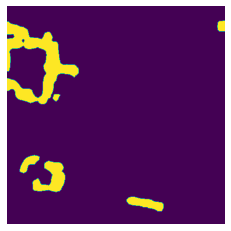

In [38]:
%matplotlib inline 
from matplotlib import pyplot as plt

masks = Image.fromarray((y_pred[58][1] * 255).astype(np.uint8)) #Выгрузка была здесь
#masks = 255 - (y_pred[12][3] * 255).astype(np.byte) 
#masks = Image.fromarray((y_prob[12][0] * 255).astype(np.uint8)) #Выгрузка была здесь
plt.imshow(masks)

plt.axis('off')


#Вывод данных

###Сохраняем маски на диск

In [39]:
count_operation = 0
for j in range(len(test_ds)):
    for i in range(len(test_ds.labels)):        
        tile_id = test_ds.ids[j]
        class_name = test_ds.labels[i].lower()
        masks = Image.fromarray((y_pred[j][i] * 255).astype(np.uint8))#вывод 
        masks = ImageOps.invert(masks)          #Отправить Без инвертирования для aguarda попробовать инвертировать building and platform
        masks.save(f'/content/gdrive/MyDrive/model_2/pred/tile_{tile_id}_mask_{class_name}.tif')#png
        count_operation += 1
print(f'Сохранено {count_operation} изображений. Операция завершена {datetime.now()}')#Контроль объема исходящих данных    

Сохранено 987 изображений. Операция завершена 2021-06-28 14:52:22.561837


###Конвертация в .npz

In [40]:
def convert_image(img_path):
    img=Image.open(img_path)
    return sparse.csr_matrix(ImageOps.invert(img),dtype=bool)
count_operation = 0
for file in os.listdir('/content/gdrive/MyDrive/model_2/pred/'):
    fname = os.path.join('/content/gdrive/MyDrive/model_2/pred_npz/', file)
    fname_tif = os.path.join('/content/gdrive/MyDrive/model_2/pred/', file)
    sparse.save_npz(os.path.splitext(fname)[0]+'.npz', convert_image(fname_tif), compressed=True)
    count_operation += 1
print(f'Сконвертировано {count_operation} изображений. Операция завершена {datetime.now()}')#Контроль объема исходящих данных

Сконвертировано 987 изображений. Операция завершена 2021-06-28 14:52:37.871381


###ZIP

In [41]:
!zip ./my_preds_k2806_2.zip /content/gdrive/MyDrive/model_2/pred_npz/*

  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_building.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1765_mask_platform.npz (deflated 31%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_building.npz (deflated 26%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1766_mask_platform.npz (deflated 35%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_aguada.npz (deflated 16%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_building.npz (deflated 12%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1767_mask_platform.npz (deflated 13%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1768_mask_aguada.npz (deflated 62%)
  adding: content/gdrive/MyDrive/model_2/pred_npz/tile_1768_mask_building.npz 